<center>
<h1>Implementation of K-means|| Algorithm


<center> Yunxuan Li, Jie Chen

### <center>__Abstract__

K-means algorithm has always been a popular method in clustering analysis. A good set initial centroids makes K-means algorithm work much more efficiently than randomly chosen initial centroids. However, the initialization process of K-means++ initialization algorithm usually costs O(k) time to achieves a good set of centroids due to its sequential nature. In this paper, we implement the K-meansll algorithm, which is firstly introduced by Bahmani, Moseley, et al in 2012. This algorithm focuses on an alternative way to initialize centroids, which takes less passes to get a good set of starting centroids. Specifically, we implement K-means++, K-meansll, K-means, optimize them with jit, cython,  test their performance and compare their computational efficiency. We also implement a parallel version of K-meansll as discussed in the original paper. A package of implemented algorithms is uploaded and ready for installation.

### <center>__Introduction__

The research paper we study in this project is "Scalable K-Means++" (Bahmani et al., 2012). K-means algorithm is a classic clutering methods, which starts with a given set of centroids and data, does clustering by update the centroids and the cluster that each data point belongs to sequantially and repetitively until the algorithm converges. The algorithm is guaranteed to converge, because in each step (either update centroids or update cluster assignments), the sum of squared error (SSE) is always non-increasing. While convergence, a bad set of initial starting centroids will increases the number of iterations a lot, leading to more computational effort and less computational efficiency. Therefore, we need to find a way to obtain a good set of starting centroids.

K-means++, an initialization algorithm for K-means, works in the way that the first centroid is selected from all data points at random, and each subsequent centroid is selected based on a probability inversely-proportional to its distance to current centroid set. This takes O(K) iteration to find K centroids. K-means++ works well in determining a good set of initial centers, but its sequential nature, i.e., the choice of each centroid depends strictly on the previous chosen centroid, limits this algorithm's possibility to be parallelly implemented. Thus K-means++ works slowly when the input dataset is large and when the number of clusters grows.

To deal with this kind of issues that come together with big data, Bahmani et al. (2012) brings up the idea of K-meansll, which is an algorithm to initialize centers that is similar to K-means++. The fundamental difference between K-meansll and K-means++ is that instead of sampling one center at each of the K iterations, the K-meansll algorithm samples multiple centers at each of K' iterations (K' < K, to be discussed in detail in next section), and recluster these centers into K clusters. The fact that multiple centers are sampled in one iteration allows researchers to implement a parallel version of this algorithm, which works very well with large dataset. It improves the computational efficiency significantly when dealing with large amount of data.

The K-meansll algorithm is suitable for various fields of researches and can be applied widely to clustering analysis when dataset is huge. It provides a way to reduce computational effort by allowing parallel processing. With the help of K-meansll, we can use K-means to perform cluster analysis more efficiently in areas such as data mining, text mining and etc. In original paper, the algorithm is applied to clustering spam emails.

The advantage of K-meansll is pretty obvious: allows for parallel processing when data is large, which is not achievable if using K-means++. On the other hand, when the dataset is not as large, using K-meansll actually cost similar, or a bit more time than K-means++. 

In this paper, we first describe the algorithms involved in original paper: K-means, K-means++, K-meansll. We then implement these algorithms in python, try optimizing them using JIT, vectorization, Cython, and develop a parallel version of K-meansll. These algorithms' performance including speed and cost are tested with a simulated dataset and a real-world dataset from the Bahmani's paper. We compare and discuss the different performances of these algorithm.

### <center>__Methods: Algorithms__

In this section, we implement two initialization methods: K-means++ and K-means||. The clustering method, K-means itself is also implemented to allow us compare the initialization and overall performance of two different initialization methods.

#### Notation and Background

Let $X=\{x_1,...,x_n \}$ be a set of points in the d-dimensional Euclidean space and let k be apositive integer specifying the number of clusters. Let $||x_i-x_j||$ denote the Eculidean distance between $x_i$ and $x_j$. For a point $x$ and a subset $Y \subseteq X$ of points, the distance is defined as $d(x,Y) = \text{min}_{y \in Y} ||x-y||$. For a subset $Y \subseteq X$ of points, let its *centriod* be given by

$$\text{centroid}(Y)=\frac{1}{|Y|}\sum_{y\in Y}y$$

Let $\mathcal{C} = \{c_1, ..., c_k \}$ be a set of points and let $Y \subseteq X$. We define the *cost* of Y with respect to $\mathcal{C}$ as 

$$\phi_Y(C)=\sum_{y\in Y} d^2(y,C) = \sum_{y \in Y} \min_{i=1,...,k}||y-c_i||^2$$

The goal of *k-means* clustering is to choose a set $\mathcal{C}$ of $k$ centers to minimize $\phi_X(C)$. When it is obvious from the text, we simply denote this as $\phi$. Let $phi*$ be the cost of the optimal k-means clustering.

#### Original k-means 

The original k-means starts with a random set of k centers. In each iteration, a clustering of X is derived from the current set of centers. The centroids of these derived clusters then become the centers for the next
iteration. The iteration is then repeated until a stable set of centers is obtained. The iterative portion of the above method is called Lloyd’s iteration.

#### Algorithm 1: k-means++ (Arthur and Vassilvitskii, 2007)

The main idea in their algorithm is to choose the centers one by one in a controlled
fashion. The central drawback of k-means++ initilizationis its inherent sequential nature: the choice of the next center depends on the current set of centers, which will stochastically bias the choice of the next center.

**Description: ** 

1: $\mathcal{C} \leftarrow$ sample a point uniformly at random from $X$

2: **while** |$\mathcal{C}$| < $k$ **do**

3: Sample $x \in X$ with probability $\frac{d^2(x,C)}{\phi_X(C)}$

4: $\mathcal{C} \leftarrow C \cup \{x\}$

5: **end while**


#### Algorithm 2:  k-means|| (Bahmani, Bahman, et al., 2012)

This algorithm works in a small number of iterations, selects more than one point in each iteration but in a non-uniform manner, and has provable approximation guarantees. It uses an *oversampling factor* $l=\Omega(k)$, which is unlike *k=means++*. The algorithm picks an initial center and computes the initial cost of the clustering after this selection. It then proceeds in $\log\psi$ iterations, where in each iteration, given the current set $\mathcal{C}$ of centers, it samples each x with probability $\frac{ld^2(x,C)}{\phi_X(C)}$. The sampled points are then added to $\mathcal{C}$, the quantity of $\phi_X(C)$ updated, and the iteration continued. 

The expected number of points chosen in each iteration is $l$ and at the end is $l log\psi$, which is typically more than $k$. To reduce the number of centers, Step 7 assigns weights to the points in C and Step
8 reclusters these weighted points to obtain k centers. 

**Description** 

1: $\mathcal{C} \leftarrow$ sample a point uniformly at random from $X$

2: $\psi \leftarrow \Phi_X(C)$

3: **for** $O(\log\psi)$ **do**

>4: $\mathcal{C}^\prime \leftarrow$ sample each point $x\in X$ independently with probability $p_x=\frac{l\cdot       
d^2(x,C)}{\phi_X(C)}$

>5: $\mathcal{C} \leftarrow \mathcal{C} \cup \mathcal{C}^\prime$

6: **end for**

7: For $x \in \mathcal{C}$, set $w_x$ to be the number of points in $X$ closer to $x$ than any other point in $\mathcal{C}$

8: Recluster the weighted points in $\mathcal{C}$ into $k$ clusters.
 

#### Implementation of the Algorithm

In [1]:
import numpy as np
import os
import pandas as pd
import random
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

Define functions for calculating distance: 

##### Note that in our package we provide specific explanation and notation for each function. For simplicity, in this report we don't use detailed docstring.

In [2]:
def euclidean_dist(a,b):
    
    return la.norm(a-b)

def distance(x,Y):
    """
    x is a single vector, Y is multiple vectors
    """
    dist=[euclidean_dist(x,y) for y in Y]
    return min(dist)

def distance_index(x,Y):
    """
    returns the index of y which is closest to x
    """
    dist=np.array([euclidean_dist(x,y) for y in Y])
    return np.argmin(dist)

K-means++: 

In [3]:
def KmeansPP(X,k):
    """
    K-means ++ Initialization
    X: dataset
    k: number of centers desired
    Returns:
    C: the centroids
    """
    random.seed(28)
    #starting with a randomly selected point.
    C=[]
    c=np.random.randint(0,len(X),1)
    C.append(X[c,])
    
    dist2=np.array([distance(X[i],C)**2 for i in range(0,len(X))])
    total_cost=sum(dist2)
    probability=dist2/total_cost
    
    while(len(C)<k):
        cc=np.random.choice(len(X), size=1, p=probability)
        C.append(X[cc])
        dist2=np.array([distance(X[i],C)**2 for i in range(0,len(X))])
        total_cost=sum(dist2)
        probability=dist2/total_cost
    return C

K-meansll:

In [4]:
def Kmeansll(k,l,X):
    
    ## k,l initialization
    """
    k=the number of clusters
    l=the oversample factor
    X=input data points we apply k-means
    
    Input: initial k and l and a set of data points X
    Output: The number of points in each cluster and the cluster assigment
    (for each of the x in C, set w_x to be the number of points in X closer to x than any other point in C)
    """
    c= np.random.choice(X.shape[0], 1)
    C = X[c,:]

    
    psi=sum([distance(x,C)**2 for x in X])  ##psi as the cost function of phi_c  
   
    for i in range(int(round(np.log(psi)))):
        dist_x=[distance(x,C)**2 for x in X]
        prob=(np.array(dist_x)*l)/sum(dist_x) 
        prob[prob>1]=1
        cc=X[np.random.binomial(1,p=prob)==1,:]
        C=np.vstack((C,cc))
        
    l_init = np.zeros(len(C))
    C_a=C
    for i in range(0,len(X)):
        index1=distance_index(X[i],C_a)
        l_init[index1]=l_init[index1] + 1
        weight=l_init/sum(l_init)
        C1=[]      
        while len(C1) < k:
            s=np.random.multinomial(1,weight).tolist()
            index2=s.index(max(s))
            C1.append(C[index2])
    return C1

K-means:

In [5]:
def Kmeans(C,X,k,initial=False):
    """
    K-means algorithm implementation
    C: initial centroids
    X: dataset
    Returns:
    C0: the final centroids
    X_C: the index of center each vector x belongs to
    """
    
    if initial:
        C0=C
    else:
        C0=X[np.random.choice(range(X.shape[0]),k)]  
    convergence=False
    
    m=0
    X_C1=np.zeros(len(X))
    X_C=np.zeros(len(X))
    while not convergence:
        C1=C0
        X_C1=X_C
        X_C=np.array([distance_index(X[i],C0)for i in range(0,len(X))])
        for i in range(0,len(C0)):
            X_Ci=X[np.where(X_C==i)]
            if np.sum(X_C==i)!=0:
                C0[i]=np.mean(X_Ci,axis=0)
        convergence=np.array_equal(X_C,X_C1)

        m=m+1
        if m>1000:
            break

    return C0,X_C,m   



### <center>__Optimization__

Because Bahmani et al.'s paper (2012) itself talks about optimizing K-means initialization algorithm, we do not aim for a better algorithm when doing optimization. In this section, we discuss the following optimizations that we have worked on:

1. Vectorization/removing for-loops/changing data structures + JIT
2. Cython
3. parallelism (this is also mentioned by the paper itself)

We also wrap up our optimized algorithm (K-means, K-means++, K-meansll) into a package called "sta663-yl491". The package is uploaded to pypl, and can be installed by using:

It can be then imported with following codes:

A package example file is also uploaded for users' reference.

** 1. Vectorization/removing for-loops/changing data structures+JIT**

We start by redefining helper functions, removing all unnecessary for-loops in functions, which is done through vectorization. While-loops are kept, as this is the core of k-means algorithm. We optimize the function further by replacing all list structure with np.array structures (which is faster and works better with JIT). Finally, we applied JIT from numba to speed this up. 

In [6]:
from numba import jit

In [7]:
@jit
def euclidean_dist(a,b):
    return la.norm(a-b)

@jit
def distance_speed(x,Y):
    """
    x is a single vector, Y is multiple vectors
    """   
    dif=x-Y
    su=np.sum(dif**2,axis=1)
    return np.sqrt(np.min(su))

@jit
def distance_speed_multi(X,Y):
    d=X[:,None]-Y
    su=np.sum(d**2,axis=2)
    return np.sqrt(np.min(su,axis=1))

@jit
def distance_index_speed(x,Y):
    """
    returns the index of y which is closest to x
    """
    dif=x-Y
    su=np.sum(dif**2,axis=1)
    return np.argmin(su)

@jit
def distance_index_multi_speed(X,Y):
    d=X[:,None]-Y
    su=np.sum(d**2,axis=2)
    return np.argmin(su,axis=1)

In [8]:
@jit
def KmeansPP_speed(X,k):
    """
    K-means ++ Initialization
    X: dataset
    k: number of centers desired
    Returns:
    C: the centroids
    """
    random.seed(28)
    #starting with a randomly selected point.
    c=np.random.randint(0,len(X),1)
    C=X[c]
    
    dist2=distance_speed_multi(X,C)
    probability=dist2/np.sum(dist2)
    
    while(len(C)<k):
        cc=np.random.choice(len(X), size=1, p=probability)
        C=np.vstack((C,X[cc]))
            
        dist2=distance_speed_multi(X,C)
        probability=dist2/np.sum(dist2)

    return C

In [9]:
@jit
def KmeansPP_speed_weighted(X,k,weight):
    """
    K-means ++ Initialization
    X: dataset
    k: number of centers desired
    Returns:
    C: the centroids
    """
    random.seed(28)

    c=np.random.randint(0,len(X),1)
    C=X[c]
    dist2=weight*distance_speed_multi(X,C)
    probability=dist2/np.sum(dist2)
    
    while(len(C)<k):
        cc=np.random.choice(len(X), size=1, p=probability)
        C=np.vstack((C,X[cc]))
            
        dist2=weight*distance_speed_multi(X,np.squeeze(np.array(C)))
        probability=dist2/np.sum(dist2)

    return C

In [10]:
@jit
def Kmeansll_speed(k,l,X):
    
    """
    k=the number of clusters
    l=the oversample factor
    X=input data points we apply k-means
    
    Input: initial k and l and a set of data points X
    Output: The number of points in each cluster and the cluster assigment
    (for each of the x in C, set w_x to be the number of points in X closer to x than any other point in C)
    """

    c= np.random.choice(X.shape[0], 1)
    C = X[c]
    psi=sum(distance_speed_multi(X,C))  
   
    for i in range(int(round(np.log(psi)))):
        dist_x=distance_speed_multi(X,C)
        prob=(np.array(dist_x)*l)/np.sum(dist_x)
        prob[prob>1]=1
        cc=X[np.random.binomial(1,p=prob)==1,:]
        C=np.vstack((C,cc))
    
    C_a=C
    
    index_total=distance_index_multi_speed(X,C_a)
    mat=np.zeros((len(X),len(C)))
    mat[np.arange(len(X)),index_total]=1
    mat_c=np.sum(mat,axis=0)
    
    weight=mat_c/sum(mat_c)    

    return KmeansPP_speed_weighted(C,k,weight=weight)

In [11]:
@jit
def Kmeans_speed(C,X,k,initial=False):
    """
    K-means algorithm implementation
    C: initial centroids
    X: dataset
    Returns:
    C0: the final centroids
    X_C: the index of center each vector x belongs to
    """
    
    if initial:
        C0=C
    else:
        C0=X[np.random.choice(range(X.shape[0]),k)]  
    convergence=False
    
    m=0
    X_C1=np.zeros(len(X))
    X_C=np.zeros(len(X))
    while not convergence:
        X_C1=X_C
        X_C=distance_index_multi_speed(X,np.squeeze(np.asarray(C0)))
        for i in range(0,len(C0)):
            X_Ci=X[np.where(X_C==i)]
            if np.sum(X_C==i)!=0:
                C0[i]=np.mean(X_Ci,axis=0)
        convergence=np.array_equal(X_C,X_C1)

        m=m+1
        if m>1000:
            break
    return C0,X_C,m   

**2. Cython**

We then try to optimize our algorithm using Cython.

In [12]:
%load_ext Cython

In [13]:
%%cython -a
from libc.math cimport sqrt
import numpy as np
import cython
cimport numpy as np
cimport cython
from cpython cimport array
import array


DTYPE = np.float64
ctypedef np.float64_t DTYPE_t
@cython.boundscheck(False)  
@cython.nonecheck(False)
    
def distance_cy(x,Y):
    """
    x is a single vector, Y is multiple vectors
    """      
    dif=x-Y
    su=np.sum(dif**2,axis=1)
    return np.sqrt(np.min(su))

def distance_multi_cy(X,Y):
   
    d=X[:,None]-Y
    su=np.sum(d**2,axis=2)
    return np.sqrt(np.min(su,axis=1))


def distance_index_cy(x,Y):
    """
    returns the index of y which is closest to x
    """
    dif=x-Y
    su=np.sum(dif**2,axis=1)
    return np.argmin(su)


def distance_index_multi_cy(X,Y):
    cdef d,su
    d=X[:,None]-Y
    su=np.sum(d**2,axis=2)
    return np.argmin(su,axis=1)

def Kmeans_cy(C,X,int k,initial=False):
    """
    K-means algorithm implementation
    C: initial centroids
    X: dataset
    Returns:
    C0: the final centroids
    X_C: the index of center each vector x belongs to
    """

    if initial:
        C0=C
    else:
        C0=X[np.random.choice(range(X.shape[0]),k)]  
    convergence=False
    
    m=0
    X_C1=np.zeros(len(X))
    X_C=np.zeros(len(X))
    while not convergence:
        X_C1=X_C
        X_C=distance_index_multi_cy(X,np.squeeze(np.asarray(C0)))
        for i in range(0,len(C0)):
            X_Ci=X[np.where(X_C==i)]
            if np.sum(X_C==i)!=0:
                C0[i]=np.mean(X_Ci,axis=0)
        convergence=np.array_equal(X_C,X_C1)

        m=m+1
        if m>1000:
            break
    return C0,X_C,m  


def KmeansPP_cy(np.ndarray[double, ndim=2]X,int k):
    """
    K-means ++ Initialization
    X: dataset
    k: number of centers desired
    Returns:
    C: the centroids
    """
    
    #starting with a randomly selected point.
    c=np.random.randint(0,len(X),1)
    C=X[c]
    
    dist2=distance_multi_cy(X,C)
    probability=dist2/np.sum(dist2)
    
    while(len(C)<k):
        cc=np.random.choice(len(X), size=1, p=probability)
        C=np.vstack((C,X[cc]))
            
        dist2=distance_multi_cy(X,C)
        probability=dist2/np.sum(dist2)

    return C

def KmeansPP_weighted_cy(X,k,weight):
    """
    K-means ++ Initialization
    X: dataset
    k: number of centers desired
    Returns:
    C: the centroids
    """
    
    #starting with a randomly selected point.

    c=np.random.randint(0,len(X),1)
    C=X[c]
    dist2=weight*distance_multi_cy(X,C)
    probability=dist2/np.sum(dist2)
    
    while(len(C)<k):
        cc=np.random.choice(len(X), size=1, p=probability)
        C=np.vstack((C,X[cc]))
            
        dist2=weight*distance_multi_cy(X,np.squeeze(np.array(C)))
        probability=dist2/np.sum(dist2)

    return C

def Kmeansll_cy(k,l,X):
    
    ## k,l initialization
    """
    k=the number of clusters
    l=the oversample factor
    X=input data points we apply k-means
    
    Input: initial k and l and a set of data points X
    Output: The number of points in each cluster and the cluster assigment
    (for each of the x in C, set w_x to be the number of points in X closer to x than any other point in C)
    """

    c= np.random.choice(X.shape[0], 1)
    C = X[c]
    psi=sum(distance_multi_cy(X,C))  
   
    for i in range(int(round(np.log(psi)))):
        dist_x=distance_multi_cy(X,C)
        prob=(np.array(dist_x)*l)/np.sum(dist_x)
        prob[prob>1]=1
        cc=X[np.random.binomial(1,p=prob)==1,:]
        C=np.vstack((C,cc))
    
    C_a=C
    
    index_total=distance_index_multi_cy(X,C_a)
    mat=np.zeros((len(X),len(C)))
    mat[np.arange(len(X)),index_total]=1
    mat_c=np.sum(mat,axis=0)
    
    weight=mat_c/sum(mat_c)    

    return KmeansPP_weighted_cy(C,k,weight=weight)

Given time limit on this project, we don't fully optimize the Cython part. However, we would like to work on detailed Cython optimization later by rewriting certian code into C++ form. However, this simple version of Cython optimization still gives a relatively good performance in terms of computational time.

**3. parallelism (this is also mentioned by the paper itself)**

To further optimize the functions and allow for parallel processing (which is also mentioned by the original paper), we hereby implemented a parallel version of K-meansll. As discussed at section 3.5 in the paper, each mapper is supposed to deal with a partition of total data, and should sample independently. Therefore, we implement a data parallelism instead of task parallelism, using multiprocessing. 

In [14]:
import multiprocessing as mp
from multiprocessing import Pool,cpu_count
from functools import partial

In [15]:
def binomial_samp(prob):
    return np.random.binomial(1,prob,1)
    
def Kmeansll_speed_py(k,l,X):
    
    """
    k=the number of clusters
    l=the oversample factor
    X=input data points we apply k-means
    
    Input: initial k and l and a set of data points X
    Output: The number of points in each cluster and the cluster assigment
    (for each of the x in C, set w_x to be the number of points in X closer to x than any other point in C)
    """

    c= np.random.choice(X.shape[0], 1)
    C = X[c]
    
    partial_dist_sp=partial(distance_speed,Y=C)
    p=Pool(processes=cpu_count())
    total_dist=p.map(partial_dist_sp,X)
    
    psi=np.sum(total_dist)

   
    for i in range(int(round(np.log(psi)))):
        partial_dist_sp=partial(distance_speed,Y=C)
        dist_x=p.map(partial_dist_sp,X)
        
        prob=(np.array(dist_x)*l)/np.sum(dist_x)  
        prob[prob>1]=1
        
        ind=p.map(binomial_samp,prob)
        a=np.array(ind)
        aa=np.squeeze(a.reshape(1,-1))
        cc=X[np.where(aa==1)]
        
        #cc=X[np.random.binomial(1,p=prob)==1,:]
        C=np.vstack((C,cc))
    
    C_a=C
    
    partial_dist_ind_sp=partial(distance_index_speed,Y=C_a)
    index_total=p.map(partial_dist_ind_sp,X)
    
    mat=np.zeros((len(X),len(C)))
    mat[np.arange(len(X)),index_total]=1
    mat_c=np.sum(mat,axis=0)
    
    weight=mat_c/sum(mat_c)    

    return KmeansPP_speed_weighted(C,k,weight=weight)

### <center>__Application__

This part is divided into 3 parts: the first section tests the algorithms on a simulated dataset. The second section tests the algorithms on a real-world dataset from the original paper. The third section compares the functions before and after optimization.  

### 1. Simulated Dataset with Known Output
Before testing on the time and cost of proposed algorithm, we first make sure the algorithm itself serves the function of clustering. In this testing case, we simulate 5 centers. For visualization purpose, we sampled centers from a 2D space.

In [16]:
random.seed(42)
mean1=[0,0]
cov1=np.array([[1, 0], [0, 1]])
x1 = np.random.multivariate_normal(mean1, cov1, 200)

mean2=[10,10]
cov2=np.array([[1, 0], [0, 1]])
x2 = np.random.multivariate_normal(mean2, cov2, 200)

mean3=[10,0]
cov3=np.array([[1, 0], [0, 1]])
x3 = np.random.multivariate_normal(mean3, cov3, 200)

mean4=[5,5]
cov4=np.array([[1,0],[0,1]])
x4 = np.random.multivariate_normal(mean4, cov4, 200)

mean5=[0,10]
cov5=np.array([[1,-0.2],[-0.2,1]])
x5 = np.random.multivariate_normal(mean5, cov5, 200)

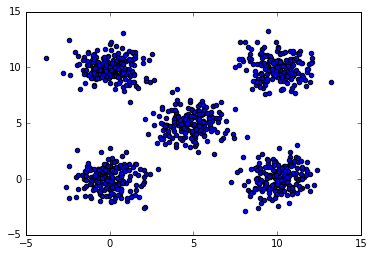

In [17]:
mixture=np.vstack((x1,x2,x3,x4,x5))
plt.scatter(mixture[:,0],mixture[:,1])

###### Kmeans++

In [18]:
true_center=np.vstack((mean1,mean2,mean3,mean4,mean5))
C=KmeansPP(mixture,5)

In [19]:
centers,indexes,itera=Kmeans(C,mixture,5,initial=True)

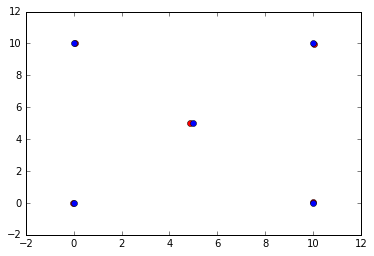

In [20]:
centers_np=np.array(centers)
plt.figure()
plt.xlim(-2,12)
plt.ylim(-2,12)
plt.plot(centers_np[:,0],centers_np[:,1],"ro")
plt.plot(true_center[:,0],true_center[:,1],"ro",color="blue")

###### K-meansll

In [21]:
C=Kmeansll(5,10,mixture)
centers,indexes,itera=Kmeans(C,mixture,5,initial=True)

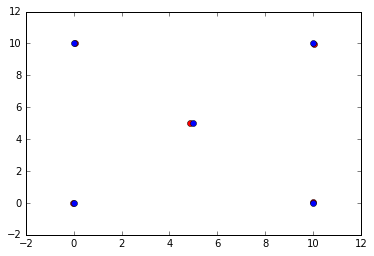

In [22]:
centers_np=np.array(centers)
plt.figure()
plt.xlim(-2,12)
plt.ylim(-2,12)
plt.plot(centers_np[:,0],centers_np[:,1],"ro")
plt.plot(true_center[:,0],true_center[:,1],"ro",color="blue")

**Comparing the centers returned by our algorithm to the true centers, we can see they are pretty close.**

**We then compare 1: time taken for algorithms; 2: result total cost, of two different initialization methods and their corresponding results.**

#### a. Time (without optimization)

In [23]:
import time

###### Kmeans

In [24]:
%%time

C=KmeansPP(mixture,5)
centers,indexes,iterations=Kmeans(C,mixture,5,initial=True)

CPU times: user 268 ms, sys: 20 ms, total: 288 ms
Wall time: 275 ms


###### K-means++

In [25]:
%%time

centers,indexes,iterations=Kmeans(C,mixture,5,initial=False)

CPU times: user 280 ms, sys: 0 ns, total: 280 ms
Wall time: 277 ms


###### K-meansll

In [26]:
%%time
C=Kmeansll(5,10,mixture)
centers,indexes,iterations=Kmeans(C,mixture,5,initial=True)

CPU times: user 5.5 s, sys: 20 ms, total: 5.52 s
Wall time: 5.53 s


#### b. Cost (without optimization)

In [27]:
def total_cost(cc,X,index):
    """calculate the final cost of the results returned by a kmeans algorithm
    C: Final centroids
    X: Dataset
    index: The centroid each x in X belongs to
    
    Returns:
    Total_cost: the sum of squared euclidean distance of all points to their centroids"""
    total=sum([euclidean_dist(X[i],cc[int(index[i])]) for i in range(0,len(X))])
    
    return total

###### K-means:

In [28]:
C=KmeansPP(mixture,5)

In [29]:
centers,indexes,iterations=Kmeans(C,mixture,5,initial=True)

In [30]:
total_cost(centers,mixture,indexes)

1278.0104767205471

###### K-means++:

In [31]:
C=KmeansPP(mixture,5)

In [32]:
centers,indexes,iterations=Kmeans(C,mixture,5,initial=False)

In [33]:
total_cost(centers,mixture,indexes)

1278.0104767205471

###### K-meansll:

In [34]:
A=Kmeansll(5,10,mixture)

In [35]:
centers,indexes,iterations=Kmeans(A,mixture,5,initial=True)

In [36]:
total_cost(centers,mixture,indexes)

1278.0104767205471

The cost of Kmeans, Kmeans++ and Kmeans|| are similar to each other, showing the K-means method does converge.

** c. Iteration**

###### K-means:

In [37]:
C=KmeansPP(mixture,5)

In [38]:
centers,indexes,iterations=Kmeans(C,mixture,5,initial=True)

In [39]:
iterations

7

###### K-means++:

In [40]:
C=KmeansPP(mixture,5)

In [41]:
centers,indexes,iterations=Kmeans(C,mixture,5,initial=False)

In [42]:
iterations

7

###### K-meansll:

In [43]:
A=Kmeansll(5,10,mixture)

centers,indexes,iterations=Kmeans(A,mixture,5,initial=True)

In [44]:
iterations

5

|  | Kmeans   || Kmeans++   || Kmeansll   |
|------|------||------||------|
| CPU Time | 268 ms|| 280 ms|| 5.5 s|
| Wall Time | 275 ms|| 277 ms|| 5.53 s|
| Cost | 1278|| 1278|| 1278|
|Iteration | 7|| 7|| 3|

### 2. Applications to real-world dataset from the paper

In [45]:
data=pd.read_csv('spambase.data.txt',sep=',',header=None)

In [46]:
data_np=np.array(data)
spam=data_np[:,0:57]
X=spam

#### a. Time:

###### K-means:

In [47]:
k=20

In [48]:
%%time

C=KmeansPP(spam,20)
centers,indexes,iterations=Kmeans(C,X,20,initial=False)

CPU times: user 2min 27s, sys: 412 ms, total: 2min 27s
Wall time: 2min 28s


###### K-means++:

In [49]:
%%time

C=KmeansPP(spam,20)
centers,indexes,iterations=Kmeans(C,X,20,initial=True)

CPU times: user 45.2 s, sys: 136 ms, total: 45.3 s
Wall time: 45.3 s


###### K-meansll:

In [50]:
%%time
C=Kmeansll(20,10,spam)
centers,indexes,iterations=Kmeans(C,X,20,initial=True)

CPU times: user 4min 40s, sys: 716 ms, total: 4min 41s
Wall time: 4min 42s


#### b. Cost:

###### K-means:

In [51]:
C=KmeansPP(spam,5)

In [52]:
centers,indexes,iterations=Kmeans(C,spam,5,initial=True)

In [53]:
total_cost(centers,X,indexes)

667005.48978177854

###### K-means++:

In [54]:
C=KmeansPP(spam,5)

In [55]:
centers,indexes,iterations=Kmeans(C,spam,5,initial=False)

In [56]:
total_cost(centers,spam,indexes)

499125.88352123823

###### K-meansll:

In [57]:
A=Kmeansll(5,10,spam)

In [58]:
centers1,indexes1,iterations=Kmeans(A,spam,5,initial=True)

In [59]:
total_cost(centers1,spam,indexes1)

499125.88352123823

The cost of Kmeans, Kmeans++ and Kmeans|| are similar to each other. 

** c. Iterations**

###### K-means:

In [60]:
C=KmeansPP(spam,5)

In [61]:
centers,indexes,iterations=Kmeans(C,spam,5,initial=False)

In [62]:
iterations

33

###### k-means++:

In [63]:
C=KmeansPP(spam,5)

In [64]:
centers,indexes,iterations=Kmeans(C,spam,5,initial=True)

In [65]:
iterations

39

##### k-meansll:

In [66]:
A=Kmeansll(5,10,spam)

In [67]:
centers1,indexes1,iterations=Kmeans(A,spam,5,initial=True)


In [68]:
iterations

31

|  | K-means   || K-means++   || K-meansll   |
|------|------||------||------|
| Wall Time | 2min 28s|| 45.3 s|| 4min 42s|
| CPU Time | 2min 27s|| 45.2 s|| 4min 40s|
| Cost | 667005|| 499125|| 499125|
|Iteration | 33|| 39|| 31|

### Comparing Time before and after Optimization Using Real-World Dataset

###### <center>K-means++:

**Before Optimization**

In [69]:
%%time
C=KmeansPP(X,20)

CPU times: user 8.69 s, sys: 32 ms, total: 8.72 s
Wall time: 8.72 s


**JIT**

In [70]:
%%time
C=KmeansPP_speed(spam,20)

CPU times: user 696 ms, sys: 420 ms, total: 1.12 s
Wall time: 1.11 s


**Cython**

In [71]:
%%time
C=KmeansPP_cy(spam,20)

CPU times: user 240 ms, sys: 148 ms, total: 388 ms
Wall time: 385 ms


###### <center>K-meansll:

**Before Optimization**

In [72]:
%%time
C=Kmeansll(20,10,spam)

CPU times: user 1min 39s, sys: 100 ms, total: 1min 39s
Wall time: 1min 39s


**JIT**

In [73]:
%%time
C=Kmeansll_speed(20,10,spam)

CPU times: user 2.64 s, sys: 5.55 s, total: 8.18 s
Wall time: 8.19 s


**Cython**

In [74]:
%%time
C=Kmeansll_cy(20,10,spam)

CPU times: user 1.25 s, sys: 2.96 s, total: 4.21 s
Wall time: 4.21 s


**Parallelism**

In [83]:
%%time
C=Kmeansll_speed_py(20,10,spam)

CPU times: user 1.76 s, sys: 212 ms, total: 1.97 s
Wall time: 16.6 s


###### <center>K-means:

**Before Optimization**

In [76]:
%%time
C=KmeansPP_speed(X,20)
centers,indexes,itera=Kmeans(C,spam,20,initial=True)

CPU times: user 2min 44s, sys: 6.29 s, total: 2min 50s
Wall time: 2min 46s


**JIT**

In [77]:
%%time
C=KmeansPP_speed(X,20)
centers,indexes,itera=Kmeans_speed(C,spam,20,initial=True)

CPU times: user 2.1 s, sys: 1.22 s, total: 3.32 s
Wall time: 3.32 s


**Cython**

In [78]:
%%time
C=KmeansPP_cy(X,20)
centers,indexes,itera=Kmeans_cy(C,spam,20,initial=True)

CPU times: user 3.97 s, sys: 3.03 s, total: 7 s
Wall time: 6.99 s


**Wall Time Comparision of Different Optimization Algorithm**


|  | K-means   || K-means++   || K-meansll   |
|------|------||------||------|
| Before Optimization  | 2min 46s || 8.71 s|| 1min 39s|
| JIT | 3.32 s|| 1.11s|| 2.43 s|
|Cython|6.99 s || 385 ms|| 4.21 s|
|Parallel |- || -||  16.6 s|

**CPU Time Comparision of Different Optimization Algorithm**


|  | K-means   || K-means++   || K-meansll   |
|------|------||------||------|
| Before Optimization  | 2min 46s  || 8.69 s|| 1min 39s|
| JIT | 2.1 s|| 696 ms|| 2.64 s|
|Cython|3.97 s || 240 ms|| 1.25 s|
|Parallel |- || -|| 1.76 s|

### <center>__Comparative Analysis with Competing Algorithms__

We compared this K-means clustering algorithm (with optimized initialization via K-meansII) with Mean Shift Clusering and Hierarchical Clustering. Because the proposed algorithm serves to optimize the initialization process, we focus on comparing the speed of three algorithms.

#### 1. Comparing with Hierarchical Clustering

In [79]:
from scipy.cluster.hierarchy import fcluster,linkage
x=spam

In [80]:
%%time
Z = linkage(X, method='single', metric='euclidean')
result=fcluster(Z,4)

CPU times: user 828 ms, sys: 20 ms, total: 848 ms
Wall time: 850 ms


#### 2. Comparing with Mean Shift Clustering

In [81]:
from sklearn.cluster import MeanShift,estimate_bandwidth
X=spam

In [82]:
%%time
bandwidth = estimate_bandwidth(X)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_

CPU times: user 2.62 s, sys: 16 ms, total: 2.64 s
Wall time: 2.64 s


Comparing the CPU time of competing algorithm, we can see that the CPU time for K-meansll is 1.25s after vectorization and Cython optimization, the K-meansll runs faster than Mean Shift Clustering but slower than Hierarchical Clustering. 

### <center>__Discussion__

In this paper, we implemented K-means++ and K-meansll as well as the original K-means clustering methods and optimized them using vectorization, JIT, Cython and parallel processing. As discussed in the introduction session, sampling multiple centers in one iteration is the key feature that allows for parallel implementation in K-meansll. Thus, parallel processing is only applicable to K-meansll.

We applied these methods to simulated data and real-world data to compare running time, total cost and number of iterations for different methods. Moreover, we compared running time of different optimization methods on K-means++, K-meansll and original K-means.Lastly, we compare K-meansll with other existing clustering methods to see if it has any advantage in running time. 

The K-meansll and K-means++ in general have a better clustering performance than randomly initialized centers. Our results also show that K-means++ algorithm runs faster than K-meansll, both before and after optimization. Personally we think this is due to the fact that datasets used here are all small (the spam data only has 4601 observations). The size of dataset may limit the performance for K-meansll.

When comparing with other clustering methods (hierarchical clustering and mean-shift clutering), K-meansll has shorter running time than Mean Shift Clustering but has slightly longer running time than Hierarchical Clustering. This shows that our algorithms performs relatively well.

In *Scalable K-Means++*, Bahmani et al. (2012) mentions a different parallel implementation of k-meansll in the MepReduce model. Details of MapReduce methods are mentioned in Dean and Ghemawat's research *MapReduce: Simplfied data processing on large clusters* (2008). Creating a MapReduce version of K-meansll in Hadoop may improve the performance. However, since we do not have access to Hadoop, we choose a different parallel processing in optimizing k-meansll. 

We would like to explore the performance of K-meansll with a much larger dataset in future to see if it outperforms other methods. In addition, as mentioned before, Cython optimization, which is the best optimization this paper has achieved for K-meansll, is not a complete optimization. We believe that if it is fully optimized, the performance of K-meansll will increase even more. We would like to research on this in future.

### <center>__Reference__

1. Bahmani, B., Moseley, B., et al. (2012) "Scalable k-means++." Proceedings of the VLDB Endowment 5.7: 622-633.
2. Arthur, D., and Vassilvitskii, S. (2006) How slow is the k-means method? In SOCG, pages 144–153.
3. Hees, J. (2015) SciPy Hierarchical Clustering and Dendrogram Tutorial https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
4. sklearn.cluster.MeanShift. http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
5. Dean, Jeffrey, and Sanjay Ghemawat. "MapReduce: simplified data processing on large clusters." Communications of the ACM 51.1 (2008): 107-113.